In [1]:
import sys
sys.path.append(r'C:\codehome\eegdata\curry-python-reader')

import curryreader as cr

raw_data = cr.read(inputfilename =r'C:\codehome\eegdata\input\Acq 2025_05_23_1458.cdt', plotdata = 0, verbosity = 2)

import mne
import numpy as np

data = np.array(raw_data['data'])
ch_names = raw_data['labels']
sfreq = raw_data['info']['samplingfreq']

data_32 = data[:, :32].T
ch_names_32 = ch_names[:32]
print(ch_names_32)

info_32 = mne.create_info(ch_names=ch_names_32, sfreq=sfreq, ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1005')
info_32.set_montage(montage)

raw_32 = mne.io.RawArray(data_32, info_32)

raw_32.filter(l_freq=1, h_freq=50, fir_design='firwin')

from mne.preprocessing import ICA
ica = ICA(n_components=32)
ica.fit(raw_32)

INFO: Reading file Acq 2025_05_23_1458.cdt ...
INFO: Number of samples = 2103400, number of channels = 37, number of trials/epochs = 1, sampling frequency = 1000.0 Hz
INFO: Found impedance matrix
INFO: Found channel labels
INFO: Found sensor positions
INFO: Found events


['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'O1', 'Oz', 'O2']
Creating RawArray with float64 data, n_channels=32, n_times=2103400
    Range : 0 ... 2103399 =      0.000 ...  2103.399 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.8s finished


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 90.6s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,77 iterations on raw data (2103400 samples)
ICA components,32
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


In [3]:
ica.exclude = [1, 4, 8]  
raw_clean = ica.apply(raw_32.copy())

Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


In [1]:
raw_clean.plot()

NameError: name 'raw_clean' is not defined

In [4]:
import mne
import numpy as np
import pandas as pd

file_num = '1-1'


sfreq = raw_clean.info['sfreq']  # 用 raw_32 的取樣頻率

trigger_samples = [
    15500, 21900, 27000, 49000, 50500, 85500, 89000, 94000,
    124500, 187500, 208500, 275000, 303000, 357000, 385000, 421500, 
    475500, 641500, 650000, 716000, 733000, 742000, 766000, 771500, 
    950000, 926000
]


freq_bands = {
    'delta': (1, 4),
    'theta': (5, 7),
    'alpha': (8, 12),
    'beta': (13, 28),
    'gamma': (30, 50),
    'all': (1, 50)
}

channel_groups = {
    'frontal': [i-1 for i in [1,2,3,4,5,6,7,8,9,10,11]],
    'temporal_left': [i-1 for i in [7,12,17,23]],
    'temporal_right': [i-1 for i in [11,16,21,27]],
    'parietal': [i-1 for i in [18,19,20,21,22,24,25,26,27,28]],
    'occipital': [i-1 for i in [30,31,32]],
    'all': [i-1 for i in range(1,33)]
}

tmin, tmax = -2.0, 2.0

def get_freqs_idx(psd_freqs, fmin, fmax):
    idx_min = (np.abs(psd_freqs - fmin)).argmin()
    idx_max = (np.abs(psd_freqs - fmax)).argmin()
    if idx_min > idx_max:
        idx_min, idx_max = idx_max, idx_min
    return np.arange(idx_min, idx_max + 1)

results = []

for i, trig in enumerate(trigger_samples):
    if trig < 0 or trig > len(raw_clean.times):
        print(f"Warning: trigger {trig} out of data range, skipped")
        continue

    events = np.array([[trig, 0, 1]]) 
    epochs = mne.Epochs(raw_clean, events, event_id=1, tmin=tmin, tmax=tmax,
                        baseline=(None, 0), preload=True, verbose=False)

    pre_epochs = epochs.copy().crop(tmin, 0)
    post_epochs = epochs.copy().crop(0, tmax)

    pre_psd_obj = pre_epochs.compute_psd(fmin=1, fmax=50, n_fft=int(sfreq*2), n_overlap=0, method='welch', verbose=False)
    post_psd_obj = post_epochs.compute_psd(fmin=1, fmax=50, n_fft=int(sfreq*2), n_overlap=0, method='welch', verbose=False)

    pre_psd = pre_psd_obj.get_data()  # shape: (epochs, channels, freqs)
    post_psd = post_psd_obj.get_data()

  
    pre_psd_avg = pre_psd.mean(axis=0)  # (channels, freqs)
    post_psd_avg = post_psd.mean(axis=0)

    psd_freqs = pre_psd_obj.freqs

    for band, (fmin, fmax) in freq_bands.items():
        freqs_idx = get_freqs_idx(psd_freqs, fmin, fmax)
        for region, chans in channel_groups.items():
            pre_power = pre_psd_avg[np.ix_(chans, freqs_idx)].mean()
            post_power = post_psd_avg[np.ix_(chans, freqs_idx)].mean()
            power_change = post_power - pre_power
            results.append({
                'event': i+1,
                'band': band,
                'region': region,
                'pre_power': pre_power,
                'post_power': post_power,
                'power_change': power_change
            })

result_df = pd.DataFrame(results)
result_df.to_csv(f'C:\\codehome\\eegdata\\output\\{file_num}_power_p.csv', index=False)
print(result_df)


     event   band          region  pre_power  post_power  power_change
0        1  delta         frontal  18.681492    6.606090    -12.075402
1        1  delta   temporal_left  22.153141   13.959190     -8.193951
2        1  delta  temporal_right  18.080262    5.616346    -12.463916
3        1  delta        parietal  20.867956   10.814763    -10.053194
4        1  delta       occipital  23.415233   12.742295    -10.672938
..     ...    ...             ...        ...         ...           ...
931     26    all   temporal_left   8.732427    7.778140     -0.954287
932     26    all  temporal_right   7.761885    7.236100     -0.525785
933     26    all        parietal   7.846244    7.243762     -0.602482
934     26    all       occipital   8.059660    7.215743     -0.843917
935     26    all             all   7.842491    7.350549     -0.491942

[936 rows x 6 columns]


In [4]:
import mne
import numpy as np
import pandas as pd

file_num = '6'

df = pd.read_csv(f'C:\\codehome\\eegdata\\output\\6\\{file_num}_clean_video_data.csv')

sfreq = raw_clean.info['sfreq']  # 直接用 raw_32 頻率

trigger_samples = [
    26495, 77006, 113377, 145503, 179004, 210038, 243137, 277568, 308209, 
    340253, 371991, 402917, 431338, 462183, 493992, 742129, 777861, 809845, 
    846827, 881015, 909346, 938910, 968842, 1003494, 1032189, 
    1073787, 1108062, 1140061, 1174161, 1206014, 1419019, 1454461, 1487205, 
    1514757, 1546663, 1582343, 1613804, 1646858, 1676821, 1706684, 1735093, 
    1766154, 1796956, 1830346, 1864866
]

trigger_times = np.array(trigger_samples) / sfreq

def calc_event_time(row):
    idx = int(row['playOrder']) - 1
    if idx < 0 or idx >= len(trigger_times):
        return np.nan
    return trigger_times[idx] + row['currentTime']

df['event_time'] = df.apply(calc_event_time, axis=1)
df = df.dropna(subset=['event_time'])
df['event_sample'] = (df['event_time'] * sfreq).astype(int)

events = np.column_stack((
    df['event_sample'].values,
    np.zeros(len(df), dtype=int),
    df['playOrder'].astype(int).values
))

tmin, tmax = -2.0, 2.0

event_id = {str(n): n for n in df['playOrder'].unique()}

epochs = mne.Epochs(raw_clean, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    baseline=(None, 0), preload=True)

freq_bands = {
    'delta': (1, 4),
    'theta': (5, 7),
    'alpha': (8, 12),
    'beta': (13, 28),
    'gamma': (30, 50),
    'all': (1, 50)
}

channel_groups = {
    'frontal': [i-1 for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]],
    'temporal_left': [i-1 for i in [7, 12, 17, 23]],
    'temporal_right': [i-1 for i in [11, 16, 21, 27]],
    'parietal': [i-1 for i in [18,19,20,21,22,24,25,26,27,28]],
    'occipital': [i-1 for i in [30, 31, 32]],
    'all': [i-1 for i in range(1,33)]
}

def get_freqs_idx(psd_freqs, fmin, fmax):
    idx_min = (np.abs(psd_freqs - fmin)).argmin()
    idx_max = (np.abs(psd_freqs - fmax)).argmin()
    if idx_min > idx_max:
        idx_min, idx_max = idx_max, idx_min
    return np.arange(idx_min, idx_max + 1)

results = []

for event_key in event_id.keys():
    sel_epochs = epochs[event_key]

    pre_epochs = sel_epochs.copy().crop(tmin, 0)
    post_epochs = sel_epochs.copy().crop(0, tmax)

    pre_psd_obj = pre_epochs.compute_psd(fmin=1, fmax=50, n_fft=int(sfreq*2), n_overlap=0, method='welch')
    post_psd_obj = post_epochs.compute_psd(fmin=1, fmax=50, n_fft=int(sfreq*2), n_overlap=0, method='welch')

    pre_psd = pre_psd_obj.get_data()
    post_psd = post_psd_obj.get_data()

    pre_psd_avg = pre_psd.mean(axis=0)
    post_psd_avg = post_psd.mean(axis=0)

    psd_freqs = pre_psd_obj.freqs

    for band, (fmin, fmax) in freq_bands.items():
        freqs_idx = get_freqs_idx(psd_freqs, fmin, fmax)
        for region, chans in channel_groups.items():
            pre_power = pre_psd_avg[np.ix_(chans, freqs_idx)].mean()
            post_power = post_psd_avg[np.ix_(chans, freqs_idx)].mean()
            results.append({
                'event': event_key,
                'band': band,
                'region': region,
                'pre_power': pre_power,
                'post_power': post_power,
                'power_change': post_power - pre_power
            })

result_df = pd.DataFrame(results)
result_df.to_csv(f'C:\\codehome\\eegdata\\output\\{file_num}_power_n.csv', index=False)
print(result_df)


Not setting metadata
29 matching events found
Setting baseline interval to [-2.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 4001 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.0

In [22]:
from mne_icalabel import label_components

result = label_components(raw_32, ica, method='iclabel')

labels = result['labels']
probs = result['y_pred_proba']

for i, label in enumerate(labels[:20]):
    print(f"Component {i}: {label}, probability: {probs[i]:.3f}")

C:\Users\Mindy\AppData\Local\Temp\ipykernel_7232\3650258168.py:3: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  result = label_components(raw_32, ica, method='iclabel')
C:\Users\Mindy\AppData\Local\Temp\ipykernel_7232\3650258168.py:3: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  result = label_components(raw_32, ica, method='iclabel')
C:\Users\Mindy\AppData\Local\Temp\ipykernel_7232\3650258168.py:3: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended 

Component 0: heart beat, probability: 0.425
Component 1: other, probability: 0.734
Component 2: other, probability: 0.454
Component 3: other, probability: 0.542
Component 4: eye blink, probability: 0.934
Component 5: brain, probability: 0.437
Component 6: other, probability: 0.559
Component 7: eye blink, probability: 0.912
Component 8: other, probability: 0.584
Component 9: other, probability: 0.589
Component 10: other, probability: 0.445
Component 11: other, probability: 0.837
Component 12: other, probability: 0.586
Component 13: other, probability: 0.633
Component 14: other, probability: 0.463
Component 15: other, probability: 0.753
Component 16: other, probability: 0.833
Component 17: other, probability: 0.922
Component 18: other, probability: 0.766
Component 19: other, probability: 0.455


In [24]:
for i, label in enumerate(labels[20:], start=20):
    print(f"Component {i}: {label}, probability: {probs[i]:.3f}")


Component 20: other, probability: 0.969
Component 21: other, probability: 0.721
Component 22: brain, probability: 0.710
Component 23: other, probability: 0.960
Component 24: brain, probability: 0.498
Component 25: other, probability: 0.523
Component 26: other, probability: 0.670
Component 27: other, probability: 0.766
Component 28: other, probability: 0.974
Component 29: other, probability: 0.915
Component 30: other, probability: 0.549
Component 31: other, probability: 0.755


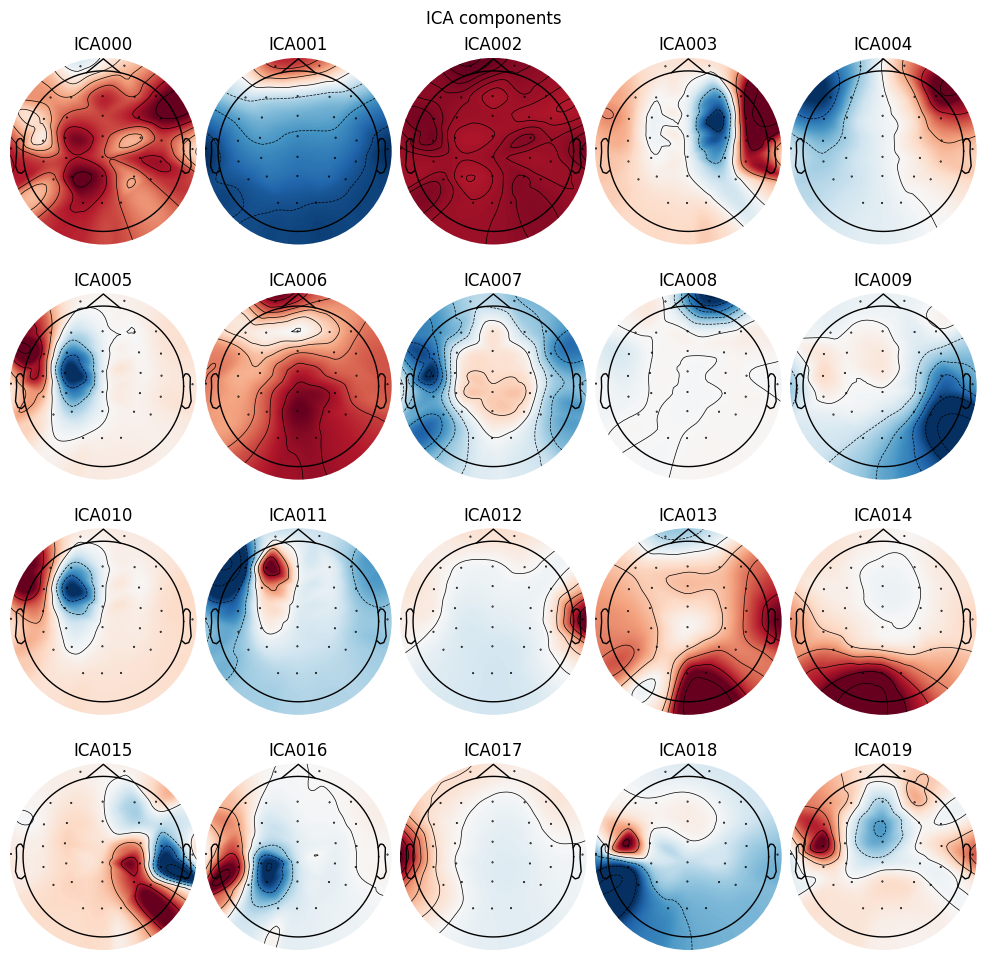

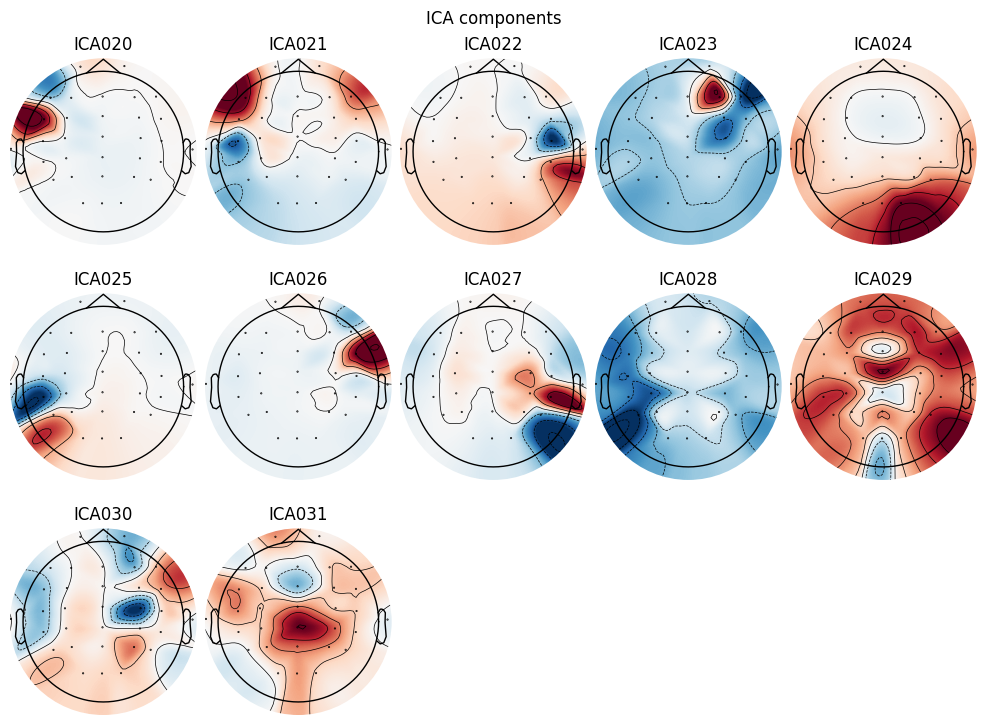

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x731.5 with 12 Axes>]

In [2]:
import matplotlib.pyplot as plt
ica.plot_components()


Creating RawArray with float64 data, n_channels=32, n_times=1008600
    Range : 0 ... 1008599 =      0.000 ...  1008.599 secs
Ready.
Using matplotlib as 2D backend.


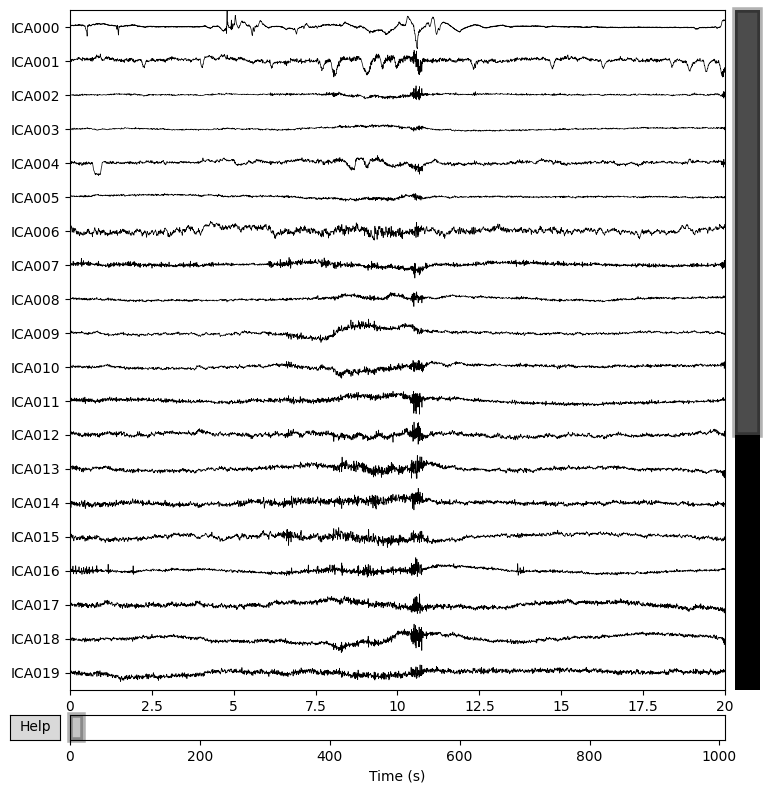

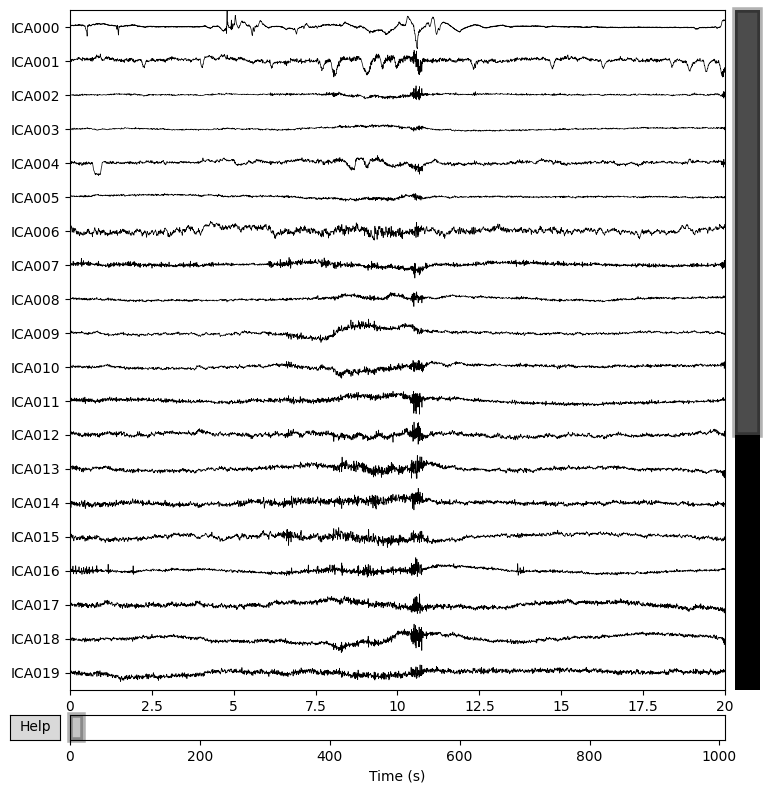

In [4]:
ica.plot_sources(raw_32)

In [2]:
ica.save('1_ica.fif')

Writing ICA solution to c:\codehome\eegdata\1_ica.fif...


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,48 iterations on raw data (1008600 samples)
ICA components,32
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—
